# Resume Parser
The goal is now to create a pipeline that can take an image of a resume and extract key information like the applicant's name, contact details, skills, and work experience into a structured JSON format

Data Loading

In [29]:
import kagglehub

path = kagglehub.dataset_download("palaksood97/resume-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'resume-dataset' dataset.
Path to dataset files: /kaggle/input/resume-dataset


In [30]:
import os

dataset_path = "/kaggle/input/resume-dataset"

print(f"Contents of '{dataset_path}':")
print(os.listdir(dataset_path))

data_folder_path = os.path.join(dataset_path, 'data')
if os.path.exists(data_folder_path):
    print(f"\nContents of '{data_folder_path}':")
    print(os.listdir(data_folder_path))

    if os.listdir(data_folder_path):
        first_category = os.listdir(data_folder_path)[0]
        category_path = os.path.join(data_folder_path, first_category)
        if os.path.isdir(category_path):
            print(f"\nContents of the first category folder '{first_category}':")
            print(os.listdir(category_path)[:5]) # Show first 5 files

Contents of '/kaggle/input/resume-dataset':
['Resumes']


In [31]:
import os

designer_resumes_path = "/kaggle/input/resume-dataset/data/data/DESIGNER"

print(f"First 5 files in '{designer_resumes_path}':")

if os.path.exists(designer_resumes_path):
    files = os.listdir(designer_resumes_path)
    print(files[:5])
else:
    print(f"Directory not found: {designer_resumes_path}")

First 5 files in '/kaggle/input/resume-dataset/data/data/DESIGNER':
Directory not found: /kaggle/input/resume-dataset/data/data/DESIGNER


PDF to image Conversion

In [32]:
!pip install pdf2image
!apt-get install -q poppler-utils


Reading package lists...
Building dependency tree...
Reading state information...
poppler-utils is already the newest version (22.02.0-2ubuntu0.10).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [33]:
import os
from pdf2image import convert_from_path
import matplotlib.pyplot as plt

pdf_filename = "22506245.pdf"
pdf_path = os.path.join("/kaggle/input/resume-dataset/data/data/DESIGNER", pdf_filename)

print(f"Converting '{pdf_path}' to images...")

try:
    images = convert_from_path(pdf_path)
    print(f"Successfully converted the PDF into {len(images)} pages (images).")

    if images:
        print("\nDisplaying the first page:")
        plt.figure(figsize=(12, 16))
        plt.imshow(images[0])
        plt.axis('off')
        plt.show()
except Exception as e:
    print(f"An error occurred: {e}")
    print("Please ensure the file path is correct and the libraries were installed successfully.")

Converting '/kaggle/input/resume-dataset/data/data/DESIGNER/22506245.pdf' to images...
An error occurred: Unable to get page count.
I/O Error: Couldn't open file '/kaggle/input/resume-dataset/data/data/DESIGNER/22506245.pdf': No such file or directory.

Please ensure the file path is correct and the libraries were installed successfully.


Preprocessing

Preprocessing each page...
Successfully preprocessed 1 pages.

Displaying the preprocessed first page:


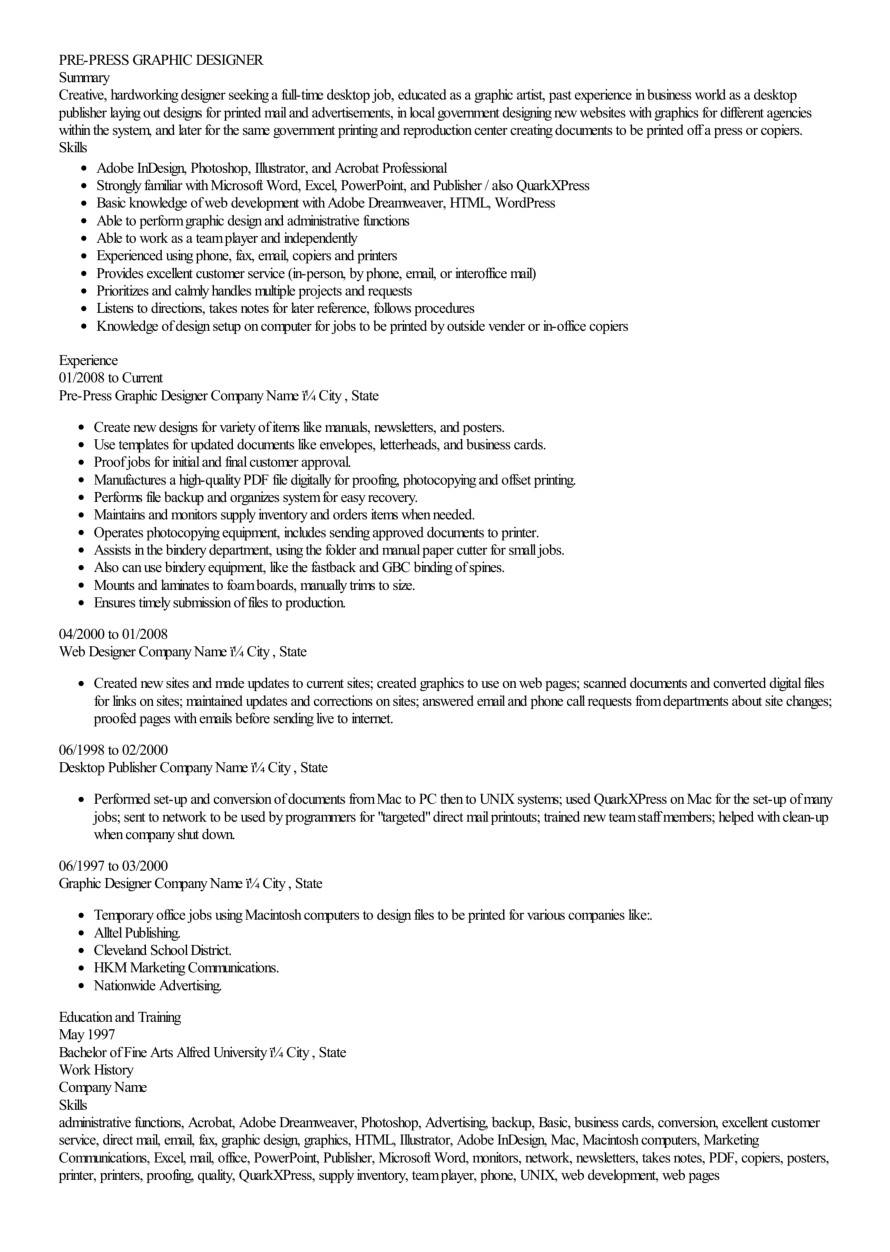

In [34]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def preprocess_image(image):

    open_cv_image = np.array(image)
    open_cv_image = open_cv_image[:, :, ::-1].copy()

    gray_image = cv2.cvtColor(open_cv_image, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

    # Binarize and invert colors
    binarized_image = cv2.adaptiveThreshold(
        blurred_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, 11, 4
    )

    # Skew Correction
    coords = cv2.findNonZero(binarized_image)
    rect = cv2.minAreaRect(coords)
    angle = rect[-1]

    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle

    (h, w) = gray_image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    deskewed_image = cv2.warpAffine(
        gray_image, M, (w, h),
        flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE
    )
    return deskewed_image

print("Preprocessing each page...")
preprocessed_images = []
for img in images:
    processed = preprocess_image(img)
    preprocessed_images.append(processed)

print(f"Successfully preprocessed {len(preprocessed_images)} pages.")

# first preprocessed page
if preprocessed_images:
    print("\nDisplaying the preprocessed first page:")
    plt.figure(figsize=(12, 16))
    plt.imshow(preprocessed_images[0], cmap='gray')
    plt.axis('off')
    plt.show()

Extracting the text

In [35]:
!pip install pytesseract


In [36]:
import pytesseract
from PIL import Image

print("Extracting text from all preprocessed pages...")

full_text = ""
for image_array in preprocessed_images:

    pil_image = Image.fromarray(image_array)
    text = pytesseract.image_to_string(pil_image)

    full_text += text + "\n\n--- Page Break ---\n\n"

print("Text extraction complete!")

#first 1000 characters
print("\nStart of Extracted Text (First 1000 Chars)")
print(full_text[:1000])
print("...")
print(" End of Preview ")

Extracting text from all preprocessed pages...
Text extraction complete!

Start of Extracted Text (First 1000 Chars)
PRE-PRESS GRAPHIC DESIGNER.
Summary

Creative, hardworking designer seeking a full-time desktop job, educated as a graphic artist, past experience in business world as a desktop
publisher laying out designs for printed mail and advertisements, in local government designing new websites with graphics for different agencies
within the system, and later for the same government printing and reproduction center creating documents to be printed offa press or copiers.
Skill

 

 

Adobe InDesign, Photoshop, Illustrator, and Acrobat Professional

Strongly familiar with Microsoft Word, Excel, PowerPoint, and Publisher / also QuarkXPress

Basic knowledge of web development with Adobe Dreamweaver, HTML, WordPress

Able to perform graphic design and administrative fiinctions

Able to work as a team player and independently

Experienced using phone, fax, email, copiers and printers



Presenting Extracted text

In [37]:
import google.generativeai as genai
import json
from google.colab import userdata
userdata.get('GOOGLE_API_KEY')
# genai.configure(api_key=userdata.get('GOOGLE_API_KEY'))

resume_prompt_template_v2 = """
Extract the key information from the provided resume text.
The text has been extracted from a PDF using an OCR process.
If you find errors in the text, please try to infer the correct information.

**Important: If a specific piece of information (like name, email, or phone) is not found in the text, you MUST return `null` for that field.** Do not invent information.

Extract the following information and provide your response only in the specified JSON format:
- name: The full name of the applicant.
- email: The email address.
- phone: The phone number.
- skills: A list of key skills.
- experience: A list of job experiences, where each job is an object with "company", "role", and "duration".
- education: A list of educational qualifications, where each is an object with "degree", "institution", and "year".

Format:
{{
    "name": "Full Name" or null,
    "email": "email@address.com" or null,
    "phone": "123-456-7890" or null,
    "skills": ["Skill 1", "Skill 2", "Skill 3"],
    "experience": [
        {{
            "company": "Company Name",
            "role": "Job Title",
            "duration": "Start Year - End Year"
        }}
    ],
    "education": [
        {{
            "degree": "Degree Name",
            "institution": "University/College Name",
            "year": "Graduation Year"
        }}
    ]
}}

Here is the text:

{extracted_text}
"""

def extract_info_with_gemini_from_text(text_from_resume):
    """
    Uses Gemini to extract structured information from a text prompt.

    """
    # Before initializing, list available models to check compatibility
    print("Listing available models:")
    for m in genai.list_models():
        if 'generateContent' in m.supported_generation_methods:
            print(f"- {m.name} (supports generateContent)")
        else:
            print(f"- {m.name} (does not support generateContent)")

    model = genai.GenerativeModel("gemini-flash-latest")

    prompt = resume_prompt_template_v2.format(extracted_text=text_from_resume)

    response = model.generate_content(prompt)

    try:
        cleaned_text = response.text.replace('```json', '').replace('```', '').strip()
        start_index = cleaned_text.find('{')
        end_index = cleaned_text.rfind('}') + 1

        if start_index == -1 or end_index == 0:
            print("!! ERROR: Could not find a JSON object in the model's response. !!")
            print(f"   Raw response was:\n---\n{response.text}\n---")
            return None

        json_string = cleaned_text[start_index:end_index]
        return json.loads(json_string)

    except (json.JSONDecodeError, IndexError) as e:
        print(f"\n!! FAILED TO PARSE JSON !!")
        print(f"   Error: {e}")
        print(f"   Raw response was:\n \n{response.text}\n")
        return None

extracted_data = extract_info_with_gemini_from_text(full_text)

if extracted_data:
    print("\nExtracted Information")
    print(json.dumps(extracted_data, indent=4))

Listing available models:
- models/embedding-gecko-001 (does not support generateContent)
- models/gemini-1.5-pro-latest (supports generateContent)
- models/gemini-1.5-pro-002 (supports generateContent)
- models/gemini-1.5-pro (supports generateContent)
- models/gemini-1.5-flash-latest (supports generateContent)
- models/gemini-1.5-flash (supports generateContent)
- models/gemini-1.5-flash-002 (supports generateContent)
- models/gemini-1.5-flash-8b (supports generateContent)
- models/gemini-1.5-flash-8b-001 (supports generateContent)
- models/gemini-1.5-flash-8b-latest (supports generateContent)
- models/gemini-2.5-pro-preview-03-25 (supports generateContent)
- models/gemini-2.5-flash-preview-05-20 (supports generateContent)
- models/gemini-2.5-flash (supports generateContent)
- models/gemini-2.5-flash-lite-preview-06-17 (supports generateContent)
- models/gemini-2.5-pro-preview-05-06 (supports generateContent)
- models/gemini-2.5-pro-preview-06-05 (supports generateContent)
- models/g